In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix
import matplotlib.pyplot as plt
import os
import mdn

Using TensorFlow backend.


In [2]:
# Able to specify which GPU to use
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 11025
overlap = 5512

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']

In [7]:
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 0,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1 ,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
import time
import librosa
import numpy as np
import soundfile as sf

def load_fold_audio_blockwise(fld, data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    f_df = data[data['fold'] == fld]
    items = []
    h_cat = []
    cat = []
    for i, sample in f_df.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        SR = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            h_cat.append(sample.h_category)
            cat.append(sample.target)
        if debug:
            print("Done")

    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(h_cat), np.array(cat)

def load_audio_blockwise(data, blocksize=1024, overlap=512, debug=False):
    start_time = time.time()
    items = []
    target = []
    for i, sample in data.iterrows():
        if debug:
            print("File Processing", end="", flush=True)
        blockgen = sf.blocks(audio_dir + sample['filename'], 
                             blocksize=blocksize, 
                             overlap=overlap, 
                             always_2d=True, 
                             fill_value=0.0)
        sr = sf.info(audio_dir + sample['filename']).samplerate
        for bl in blockgen:
            if not np.any(bl):
                continue
            if debug:
                print(".", end="", flush=True)
            y = bl.transpose()
            y = y[:int(blocksize)]
            y = y[np.newaxis, :]
            items.append(y)
            target.append(sample.h_category)
        if debug:
            print("Done")
    print("\tProcessing Time: " + str(time.time() - start_time))
    return np.vstack(items), np.array(target)

In [11]:
c_data, targets, c_targets = load_fold_audio_blockwise(1, dataset, blocksize, overlap)
# c_data, targets = load_fold_audio(1, dataset)
print(c_data.shape)

	Processing Time: 6.325226783752441
(14019, 1, 11025)


In [12]:
a_data = c_data[targets == 0]
a_targ = c_targets[targets == 0]
i_data = c_data[targets == 1]
i_targ = c_targets[targets == 1]

In [13]:
names_a = []
for name in np.unique(a_targ):
    names_a.append(classes[name])
names_i = []
for name in np.unique(i_targ):
    names_i.append(classes[name])
print(names_a)
print(names_i)

['dog', 'rooster', 'pig', 'cow', 'frog', 'cat', 'hen', 'insects', 'sheep', 'crow', 'crickets', 'chirping_birds', 'crying_baby', 'sneezing', 'clapping', 'breathing', 'coughing', 'laughing', 'snoring']
['rain', 'sea_waves', 'crackling_fire', 'water_drops', 'wind', 'pouring_water', 'toilet_flush', 'thunderstorm', 'footsteps', 'brushing_teeth', 'drinking_sipping', 'door_wood_knock', 'mouse_click', 'keyboard_typing', 'door_wood_creaks', 'can_opening', 'washing_machine', 'vacuum_cleaner', 'clock_alarm', 'clock_tick', 'glass_breaking', 'helicopter', 'chainsaw', 'siren', 'car_horn', 'engine', 'train', 'church_bells', 'airplane', 'fireworks', 'hand_saw']


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
                        c_data, targets, test_size=0.20, random_state=42)

## High-Level Shallow Nets
Train binary shallow nets for high level categories(animals, natural, human, domestic, urban)

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
import keras.metrics as kmet
from kapre.time_frequency import Melspectrogram, Spectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise

ensemble_num = 10
num_hidden_neurons = 10
dropout = 0.25

epochs = 100
batch = 128

def gpu_mfcc_shallow_net():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu', input_shape=(128,)))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [16]:
from keras.models import Model
from keras.layers import Input, LSTM, RepeatVector

def prepare_listener(timesteps,
                     input_dim,
                     latent_dim,
                     optimizer_type,
                     loss_type):
    """Prepares Seq2Seq autoencoder model

        Args:
            :param timesteps: The number of timesteps in sequence
            :param input_dim: The dimensions of the input
            :param latent_dim: The latent dimensionality of LSTM
            :param optimizer_type: The type of optimizer to use
            :param loss_type: The type of loss to use

        Returns:
            Autoencoder model, Encoder model
    """

    inputs = Input(shape=(timesteps, input_dim))

    encoded = LSTM(int(input_dim / 2), 
                   activation="relu", 
                   return_sequences=True)(inputs)

    encoded = LSTM(latent_dim, 
                   activation="relu", 
                   return_sequences=False)(encoded)

    decoded = RepeatVector(timesteps)(encoded)

    decoded = LSTM(int(input_dim / 2), 
                   activation="relu", 
                   return_sequences=True)(decoded)

    decoded = LSTM(input_dim, 
                   return_sequences=True)(decoded)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder.compile(optimizer=optimizer_type, 
                        loss=loss_type,  
                        metrics=['acc'])

    return autoencoder, encoder

In [17]:
clas = KerasClassifier(build_fn=gpu_mfcc_shallow_net, epochs=epochs, batch_size=batch, validation_split=0.15)
history = clas.fit(train_X, train_y)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_1 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dens

Epoch 34/100
9532/9532 [==============================] - 5s 483us/step - loss: 0.4148 - acc: 0.7997 - mean_absolute_error: 0.2876 - val_loss: 0.4926 - val_acc: 0.7522 - val_mean_absolute_error: 0.3145
Epoch 35/100
9532/9532 [==============================] - 5s 479us/step - loss: 0.4098 - acc: 0.8029 - mean_absolute_error: 0.2837 - val_loss: 0.4840 - val_acc: 0.7588 - val_mean_absolute_error: 0.3180
Epoch 36/100
9532/9532 [==============================] - 5s 495us/step - loss: 0.4154 - acc: 0.8019 - mean_absolute_error: 0.2872 - val_loss: 0.4867 - val_acc: 0.7629 - val_mean_absolute_error: 0.3198
Epoch 37/100
9532/9532 [==============================] - 5s 484us/step - loss: 0.4070 - acc: 0.8054 - mean_absolute_error: 0.2810 - val_loss: 0.4888 - val_acc: 0.7617 - val_mean_absolute_error: 0.3152
Epoch 38/100
9532/9532 [==============================] - 5s 487us/step - loss: 0.4080 - acc: 0.8042 - mean_absolute_error: 0.2813 - val_loss: 0.4837 - val_acc: 0.7617 - val_mean_absolute_erro

9532/9532 [==============================] - 5s 481us/step - loss: 0.3330 - acc: 0.8431 - mean_absolute_error: 0.2263 - val_loss: 0.4717 - val_acc: 0.7885 - val_mean_absolute_error: 0.2774
Epoch 75/100
9532/9532 [==============================] - 5s 485us/step - loss: 0.3284 - acc: 0.8438 - mean_absolute_error: 0.2248 - val_loss: 0.4983 - val_acc: 0.7772 - val_mean_absolute_error: 0.2754
Epoch 76/100
9532/9532 [==============================] - 5s 506us/step - loss: 0.3308 - acc: 0.8418 - mean_absolute_error: 0.2260 - val_loss: 0.4981 - val_acc: 0.7790 - val_mean_absolute_error: 0.2891
Epoch 77/100
9532/9532 [==============================] - 5s 486us/step - loss: 0.3349 - acc: 0.8372 - mean_absolute_error: 0.2277 - val_loss: 0.4965 - val_acc: 0.7825 - val_mean_absolute_error: 0.2676
Epoch 78/100
9532/9532 [==============================] - 5s 481us/step - loss: 0.3382 - acc: 0.8351 - mean_absolute_error: 0.2259 - val_loss: 0.5443 - val_acc: 0.7540 - val_mean_absolute_error: 0.3101
Epo

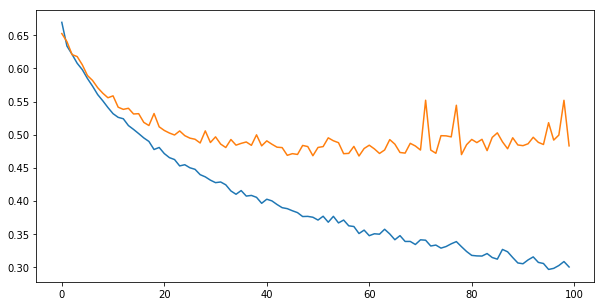

In [18]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.800641940085592
Confusion matrix, without normalization
[[ 693  350]
 [ 209 1552]]


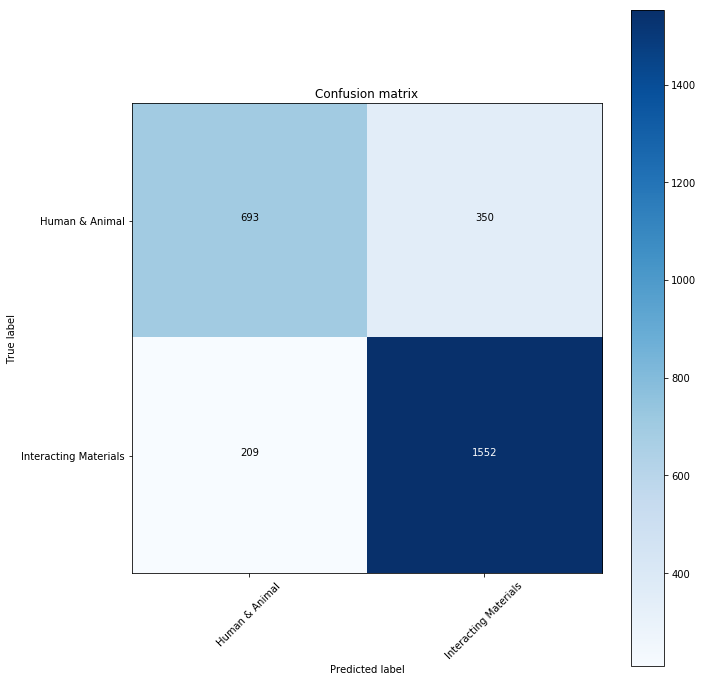

In [19]:
pred = clas.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# Deep Net
Separate into classes

# Animal Sounds

In [28]:
def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(19, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [29]:
train_X, test_X, train_y, test_y = train_test_split(
                        a_data, a_targ, test_size=0.20, random_state=56)

In [30]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, epochs=epochs, batch_size=batch, validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_4 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
__________

3515/3515 [==============================] - 2s 532us/step - loss: 1.3322 - acc: 0.5727 - mean_absolute_error: 0.0585 - val_loss: 1.4502 - val_acc: 0.5845 - val_mean_absolute_error: 0.0590
Epoch 34/100
3515/3515 [==============================] - 2s 489us/step - loss: 1.3255 - acc: 0.5781 - mean_absolute_error: 0.0581 - val_loss: 1.4577 - val_acc: 0.5717 - val_mean_absolute_error: 0.0572
Epoch 35/100
3515/3515 [==============================] - 2s 523us/step - loss: 1.3063 - acc: 0.5869 - mean_absolute_error: 0.0570 - val_loss: 1.4500 - val_acc: 0.5717 - val_mean_absolute_error: 0.0573
Epoch 36/100
3515/3515 [==============================] - 2s 515us/step - loss: 1.2955 - acc: 0.5900 - mean_absolute_error: 0.0567 - val_loss: 1.4326 - val_acc: 0.5878 - val_mean_absolute_error: 0.0575
Epoch 37/100
3515/3515 [==============================] - 2s 474us/step - loss: 1.2865 - acc: 0.5895 - mean_absolute_error: 0.0563 - val_loss: 1.4078 - val_acc: 0.5862 - val_mean_absolute_error: 0.0566
Epo

Epoch 74/100
3515/3515 [==============================] - 2s 510us/step - loss: 0.9540 - acc: 0.6930 - mean_absolute_error: 0.0435 - val_loss: 1.3013 - val_acc: 0.6361 - val_mean_absolute_error: 0.0467
Epoch 75/100
3515/3515 [==============================] - 2s 535us/step - loss: 0.9493 - acc: 0.7067 - mean_absolute_error: 0.0432 - val_loss: 1.2539 - val_acc: 0.6393 - val_mean_absolute_error: 0.0475
Epoch 76/100
3515/3515 [==============================] - 2s 503us/step - loss: 0.9257 - acc: 0.7053 - mean_absolute_error: 0.0426 - val_loss: 1.2795 - val_acc: 0.6409 - val_mean_absolute_error: 0.0466
Epoch 77/100
3515/3515 [==============================] - 2s 503us/step - loss: 0.9099 - acc: 0.7138 - mean_absolute_error: 0.0414 - val_loss: 1.2527 - val_acc: 0.6425 - val_mean_absolute_error: 0.0470
Epoch 78/100
3515/3515 [==============================] - 2s 529us/step - loss: 0.9193 - acc: 0.7090 - mean_absolute_error: 0.0420 - val_loss: 1.2460 - val_acc: 0.6602 - val_mean_absolute_erro

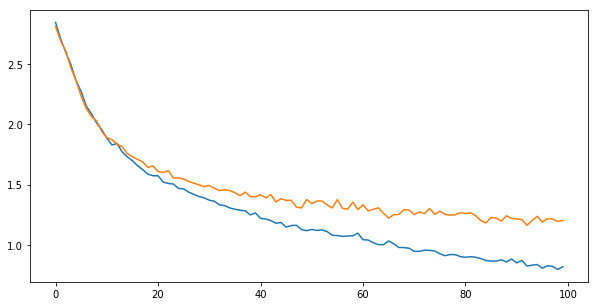

In [31]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.6657004830917874
Confusion matrix, without normalization
[[38  0  0  0  1  3  0  0  0  1  0  0  0  2  1  1  2  1  3]
 [ 7 15  0  0  1  3  5  0  0  3  0  1  3  1  0  0  2  1  0]
 [ 0  0 48  1  0  0  0  1  0  1  0  0  2  1  1  0  0  0  0]
 [ 5  0  0 29  0  4  2  2  2  0  0  0  1 10  3  3  1  0  2]
 [ 1  0  0  0 31  5  1  1  0  3  0  0  0  1  3  0  1  1  0]
 [ 1  1  0  1  0 34  1  1  0  0  0  0  3  3  0  0  0  0  4]
 [ 3  0  1  0  1  1 35  1  0  0  0  1  2  1  0  4  1  3  2]
 [ 1  0  0  2  0  0  0 35  0  0  1  0  0  0  0  0  1  0  8]
 [ 1  0  0  4  1  0  0  2 57  1  0  1  3  1  1  0  1  4  1]
 [ 2  0  1  0  0  0  0  2  0 45  0  1  0  5  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0 71  0  0  2  0  0  0  0  0]
 [ 1  0  0  0  1  2  0  1  0  3  4 46  1  0  0  0  1  0  2]
 [ 4  0  3  0  0  4  6  2  0  0  1  2 27  0  1  2  1  3  3]
 [ 2  0  2  0  1  0  0  1  1  1  0  1  1 17  0  0  0  0  2]
 [ 1  0  0  0  0  0  0  0  0  0  0  0  0  0 57  0  0  0  0]
 [ 2  0  1  1  0  0  1  1  0  1  0  0  1 

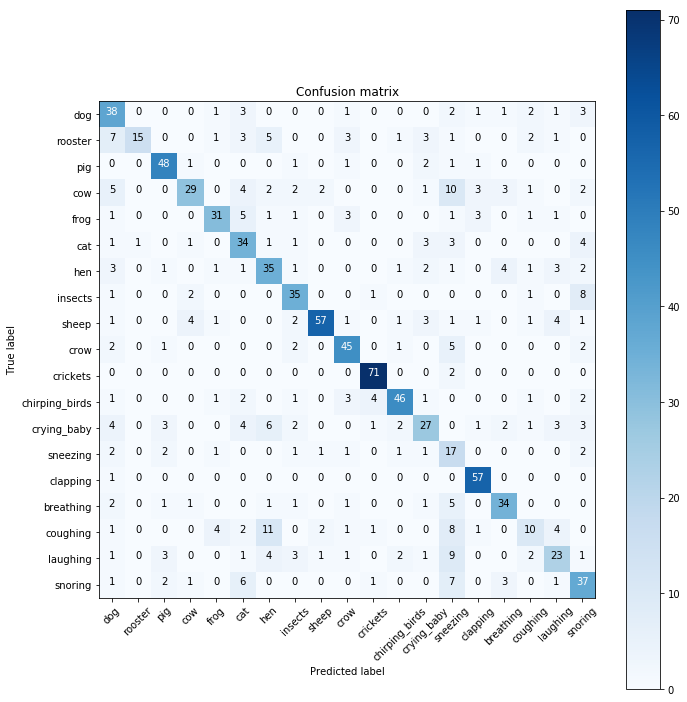

In [32]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

# Interacting Materials

In [33]:
def gpu_mfcc_deep_net_i():
    # Create Model
    model = Sequential()
    model.add(Melspectrogram(
        sr=44100,
        n_mels=128,
        power_melgram=1.0,
        input_shape=(1, 11025),
        trainable_fb=False,
        fmin = 800,
        fmax = 8000
    ))
    model.add(Convolution2D(32, 9, 9, name='conv1', activation='relu'))
    model.add(MaxPooling2D((25, 17)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', input_shape=(32,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(31, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', kmet.mae])
    
    model.summary()

    
    return model

In [34]:
train_X, test_X, train_y, test_y = train_test_split(
                        i_data, i_targ, test_size=0.20, random_state=75)

In [35]:
inter = KerasClassifier(build_fn=gpu_mfcc_deep_net_i, epochs=epochs, batch_size=batch, validation_split=0.15)
history = inter.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
melspectrogram_5 (Melspectro (None, 128, 44, 1)        296064    
_________________________________________________________________
conv1 (Conv2D)               (None, 120, 36, 32)       2624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 2, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
__________

6016/6016 [==============================] - 3s 480us/step - loss: 1.3707 - acc: 0.5505 - mean_absolute_error: 0.0374 - val_loss: 1.3870 - val_acc: 0.5565 - val_mean_absolute_error: 0.0366
Epoch 34/100
6016/6016 [==============================] - 3s 484us/step - loss: 1.3687 - acc: 0.5492 - mean_absolute_error: 0.0372 - val_loss: 1.3851 - val_acc: 0.5763 - val_mean_absolute_error: 0.0372
Epoch 35/100
6016/6016 [==============================] - 3s 469us/step - loss: 1.3650 - acc: 0.5570 - mean_absolute_error: 0.0369 - val_loss: 1.4051 - val_acc: 0.5763 - val_mean_absolute_error: 0.0367
Epoch 36/100
6016/6016 [==============================] - 3s 476us/step - loss: 1.3576 - acc: 0.5598 - mean_absolute_error: 0.0369 - val_loss: 1.3289 - val_acc: 0.5951 - val_mean_absolute_error: 0.0363
Epoch 37/100
6016/6016 [==============================] - 3s 479us/step - loss: 1.3046 - acc: 0.5738 - mean_absolute_error: 0.0358 - val_loss: 1.3567 - val_acc: 0.5782 - val_mean_absolute_error: 0.0362
Epo

Epoch 74/100
6016/6016 [==============================] - 3s 557us/step - loss: 0.9858 - acc: 0.6709 - mean_absolute_error: 0.0279 - val_loss: 1.1156 - val_acc: 0.6629 - val_mean_absolute_error: 0.0289
Epoch 75/100
6016/6016 [==============================] - 3s 518us/step - loss: 0.9838 - acc: 0.6749 - mean_absolute_error: 0.0278 - val_loss: 1.1173 - val_acc: 0.6657 - val_mean_absolute_error: 0.0283
Epoch 76/100
6016/6016 [==============================] - 3s 466us/step - loss: 0.9717 - acc: 0.6792 - mean_absolute_error: 0.0275 - val_loss: 1.0847 - val_acc: 0.6629 - val_mean_absolute_error: 0.0283
Epoch 77/100
6016/6016 [==============================] - 3s 474us/step - loss: 0.9545 - acc: 0.6812 - mean_absolute_error: 0.0270 - val_loss: 1.0498 - val_acc: 0.6846 - val_mean_absolute_error: 0.0277
Epoch 78/100
6016/6016 [==============================] - 4s 638us/step - loss: 0.9470 - acc: 0.6882 - mean_absolute_error: 0.0269 - val_loss: 1.0903 - val_acc: 0.6601 - val_mean_absolute_erro

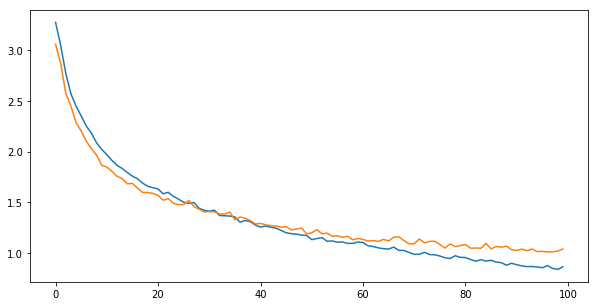

In [36]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

0.6587570621468927
Confusion matrix, without normalization
[[54  2  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0 48  0  0  2  0  1  2  0  0  1  0  0  0  0  0  2  0  0  0  0  4  0  0
   0  2  0  0  0  0  0]
 [ 0  0 48  0  0  0  0  0  3  0  0  0  0  6  0  1  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0  0  0  1  6  5  0  7  0  0  1  4  1  0  0  0
   0  0  0  0  0  1  0]
 [ 1  8  0  0 52  0  1  2  0  0  0  0  0  0  0  0  0  0  1  0  0  1  0  0
   0  3  0  0  0  0  0]
 [ 0  0  1  3  0 21  0  0  0  1  0  0  2 10  0  3  0  0  0  0  2  0  0  0
   0  0  0  0  0  0  0]
 [ 1  2  4  1  0  0 37  0  0  0  0  0  1  1  0  0  1  0  0  0  0  0  0  0
   0  4  0  0  0  0  0]
 [ 0  1  0  0  3  0  0 28  0  0  0  0  0  5  0  2  0  0  0  0  0  1  0  0
   0  6  0  0  3 11  1]
 [ 0  0  7  0  0  0  0  0 33  0  2  0  0  2  0  2  0  0  0  2  0  0  0  0
   0  0  0  0  0  3  0]
 [ 0  0  6  0  0  4  1  0  2 46  1  0  1  0  0  0  0  0  0 

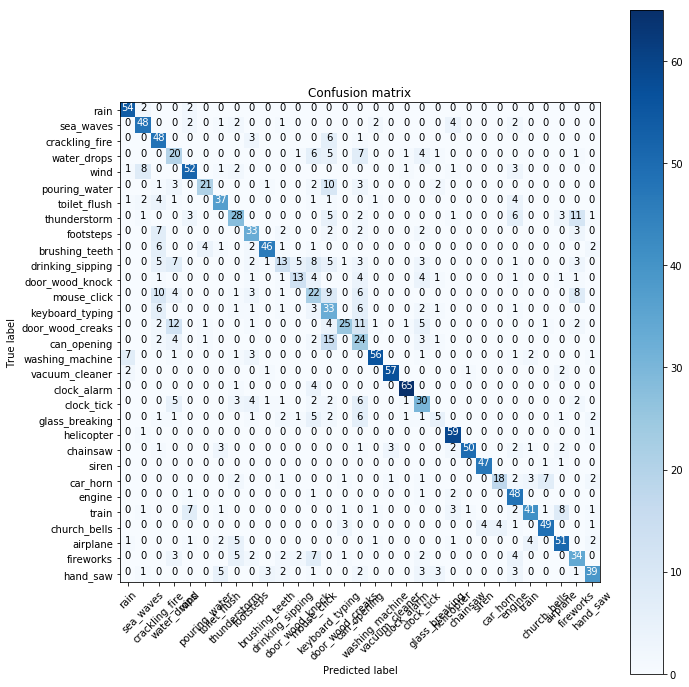

In [37]:
pred = inter.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

# All Data

In [38]:
X2, y2, yy2 = load_fold_audio_blockwise(2, dataset, blocksize, overlap)
X3, y3, yy3 = load_fold_audio_blockwise(3, dataset, blocksize, overlap)
X4, y4, yy4 = load_fold_audio_blockwise(4, dataset, blocksize, overlap)
X5, y5, yy5 = load_fold_audio_blockwise(5, dataset, blocksize, overlap)

	Processing Time: 6.750664710998535
	Processing Time: 6.394994258880615
	Processing Time: 6.191651105880737
	Processing Time: 5.682743072509766


In [39]:
X = np.vstack((X2, X3, X4, X5))
print(X.shape)

(56774, 1, 11025)


In [40]:
y = np.concatenate((y2, y3, y4, y5))
print(y.shape)

(56774,)


In [ ]:
yy = np.concatenate((yy2, yy3, yy4, yy5))
print(yy.shape)

(56774,)


0.7146581181526755
Confusion matrix, without normalization
[[12173  8931]
 [ 7269 28401]]


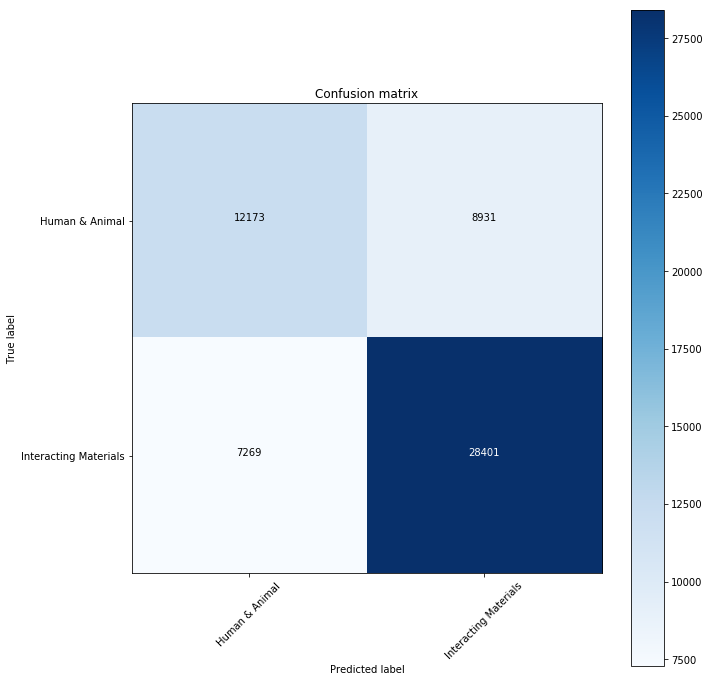

In [ ]:
pred = clas.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [ ]:
test_a_data = X[y == 0]
test_a_targ = yy[y == 0]
test_i_data = X[y == 1]
test_i_targ = yy[y == 1]

In [ ]:
pred = anim.predict(test_a_data)
print(metrics.accuracy_score(test_a_targ, pred))
cm = metrics.confusion_matrix(test_a_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_a)
plt.show()

In [ ]:
pred = inter.predict(test_i_data)
print(metrics.accuracy_score(test_i_targ, pred))
cm = metrics.confusion_matrix(test_i_targ, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names_i)
plt.show()

In [ ]:
clas.predict_proba(X)